<a href="https://colab.research.google.com/github/mahbodnr/Mask-Detection/blob/main/Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setups

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from google.colab import files
from base64 import b64decode, b64encode
import numpy as np
import cv2
import PIL
from PIL import ImageDraw
import io
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchsummary import summary

!pip install mmcv
!pip install facenet_pytorch
!pip install Augmentor
!pip install pytube
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import Augmentor
import mmcv
from pytube import Playlist, YouTube

%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_PATH = "/content/drive/Shareddrives/TeamDrive/Data/MaskDetection"
os.chdir(PROJECT_PATH)

In [ ]:
label_text = { 0:"Correctly Masked",
              1:"Incorrectly Masked",
              2:"Unmasked"
              }
class_colors= {0: (0,255,0),    #Green
               1: (0,100,255),  #Orange
               2: (0,0,255),    #Red
               }

#Download data
Dataset: github.com/cabani/MaskedFace-Net <br><br>CMFD:<br>Part 1: https://drive.google.com/file/d/17-FCstm8Fz3bDzFgTmOWHa_c39lTR_1P/view?usp=sharing<br>Pert 2: https://drive.google.com/file/d/1XClQlP9_V6UmmnwTyzjF28vlrVHNSw2H/view?usp=sharing
<br>IMFD:<br>Part 1: https://drive.google.com/file/d/1gjltyD_MnNWcnd56NnjUOizdi39CUEPF/view?usp=sharing<br>Pert 2: https://drive.google.com/file/d/1qvbcuTHSLBTxQd3wXNAUIYVXBBJCa2WF/view?usp=sharing<br>UMFD:<br>https://drive.google.com/drive/folders/1tg-Ur7d4vk1T8Bn0pPpUSQPxlPGBlGfv

# Load data



PRIJECT_PATH<br><br>
├───Train <br>
│   ├─── CMF<br>
│   │    ├─── 00000<br>
│   │    │      00001.png<br>
│   │    │      00002.png<br>
│   │           ...<br>
│   │    ├─── 10000<br>
│   │    │      10001.png<br>
│   │    │      10002.png<br>
│   │           ...<br>
│        ...<br>
│   ├─── IMF<br>
│   │    ├─── 00000<br>
│   │    │      00001.png<br>
│   │    │      00002.png<br>
│   │           ...<br>
│   │    ├─── 10000<br>
│   │    │      10001.png<br>
│   │    │      10002.png<br>
│   │           ...<br>
│        ...<br>
│   ├─── UMF<br>
│   │    ├─── 00000<br>
│   │    │      00001.png<br>
│   │    │      00002.png<br>
│   │           ...<br>
│   │    ├─── 10000<br>
│   │    │      10001.png<br>
│   │    │      10002.png<br>
│   │           ...<br>
│        ...<br>

├───Test<br>
│   ├─── CMF<br>
│   ├─── IMF<br>
│   └─── UMF<br>

### Data Augmentation

In [ ]:
p = Augmentor.Pipeline()

p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.5)
p.random_color(probability = 0.5, min_factor = 0.2, max_factor = 0.8)
p.random_contrast(probability = 0.5,  min_factor = 0.2, max_factor = 0.8)
p.random_brightness(probability = 0.5 , min_factor = 0.3, max_factor = 0.8)

### Define Dataloaders

In [ ]:
batch_size = 64
workers = 4
split_rate = 0.8

trans = transforms.Compose([
    p.torch_transform(), #Augmentation
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    fixed_image_standardization,
])
dataset = datasets.ImageFolder(f'{PROJECT_PATH}/Train', transform= trans )

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(split_rate * len(img_inds))]
val_inds = img_inds[int(split_rate * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=128,
    sampler=SubsetRandomSampler(val_inds)
)

print(dataset.class_to_idx)
for i, label in enumerate(dataset.class_to_idx.values()):
    print(f'Class', i, ':', (np.array(dataset.targets)==label).sum(), end = '  ')

{'CMDF': 0, 'IMDF': 1, 'UMDF': 2}
Class 0 : 5758  Class 1 : 5737  Class 2 : 6000  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Model

##Set Device

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {DEVICE}')

Running on: cuda:0


##Define Model

https://github.com/timesler/facenet-pytorch

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
    ).to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(rate=False, per_sample=False),
    'acc': training.accuracy
    }
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

## Load Model Weights if Exist

In [ ]:
from pprint import pprint
if os.path.exists(PROJECT_PATH + '/checkpoint/MaskDetection_Resnet.pt'):
    checkpoint = torch.load(PROJECT_PATH + '/checkpoint/MaskDetection_Resnet.pt',  map_location=torch.device(DEVICE))
    resnet.load_state_dict(checkpoint['model_state_dict'])
    print('epoch:', checkpoint['epoch'], '\nepoch details: ', end = '')
    pprint( checkpoint['epoch_details'])
    resnet.eval()

epoch: 6 
epoch details: {'train_loss': tensor(0.0059, device='cuda:0'),
 'train_metrics': {'acc': tensor(0.9987, device='cuda:0'),
                   'fps': tensor(3.2988, device='cuda:0')},
 'val_loss': tensor(0.0060, device='cuda:0'),
 'val_metrics': {'acc': tensor(0.9989, device='cuda:0'),
                 'fps': tensor(6.2771, device='cuda:0')}}


#Train Model

In [ ]:
epochs = 10

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
min_val_loss, _ = training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=DEVICE,
    writer=writer
)
for epoch in range(1, epochs + 1):
    print('\nEpoch {}/{}'.format(epoch, epochs))
    print('-' * 10)
    #Train
    resnet.train()
    train_loss, train_metrics = training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=DEVICE,
        writer=writer
    )
    # Validate
    resnet.eval()
    val_loss, val_metrics = training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=DEVICE,
        writer=writer
    )
    #Save Checkpoint
    if val_loss < min_val_loss:
        torch.save({
            'epoch': epoch,
            'epoch_details': {
                'train_loss':train_loss, 'train_metrics':train_metrics,
                'val_loss':val_loss, 'val_metrics':val_metrics},
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PROJECT_PATH + '/checkpoint/MaskDetection_Resnet.pt')
        min_val_loss = val_loss

writer.close()



Initial
----------
Valid |    28/28   | loss:    1.1080 | fps:   18.1958 | acc:    0.3495   

Epoch 1/10
----------
Train |   219/219  | loss:    0.0865 | fps:    9.1927 | acc:    0.9710   
Valid |    28/28   | loss:    2.0239 | fps:    6.3563 | acc:    0.3462   

Epoch 2/10
----------
Train |   219/219  | loss:    0.0247 | fps:    3.2937 | acc:    0.9938   
Valid |    28/28   | loss:    1.6144 | fps:    6.1322 | acc:    0.3462   

Epoch 3/10
----------
Train |   219/219  | loss:    0.0213 | fps:    3.2456 | acc:    0.9948   
Valid |    28/28   | loss:    3.3177 | fps:    6.0970 | acc:    0.3501   

Epoch 4/10
----------
Train |   219/219  | loss:    0.0198 | fps:    3.2432 | acc:    0.9944   
Valid |    28/28   | loss:    4.7187 | fps:    6.2864 | acc:    0.3467   

Epoch 5/10
----------
Train |   219/219  | loss:    0.0134 | fps:    3.2498 | acc:    0.9966   
Valid |    28/28   | loss:    5.0124 | fps:    6.2184 | acc:    0.3456   

Epoch 6/10
----------
Train |   219/219  | loss: 

###Tensorboard

In [ ]:
%tensorboard --logdir $PROJECT_PATH/runs

#Test Model

In [ ]:
# !rmdir /content/drive/My\ Drive/Projects/MaskDetection/test/.ipynb_checkpoints
batch_size = 64
workers = 2
trans = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    fixed_image_standardization,
])
test_dataset = datasets.ImageFolder(PROJECT_PATH + '/Test/', transform= trans )
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
test_loader = DataLoader(
    test_dataset,
    num_workers=workers,
    batch_size=batch_size,
    shuffle = True
)

resnet.eval()
training.pass_epoch(
    resnet, loss_fn, test_loader,
    batch_metrics=metrics, show_running=True, device=DEVICE,
    writer=writer
)

Valid |    46/46   | loss:    0.0038 | fps:  258.9084 | acc:    0.9990   


(tensor(0.0038), {'acc': tensor(0.9990), 'fps': tensor(258.9084)})

##Plot of the results (test dataset)

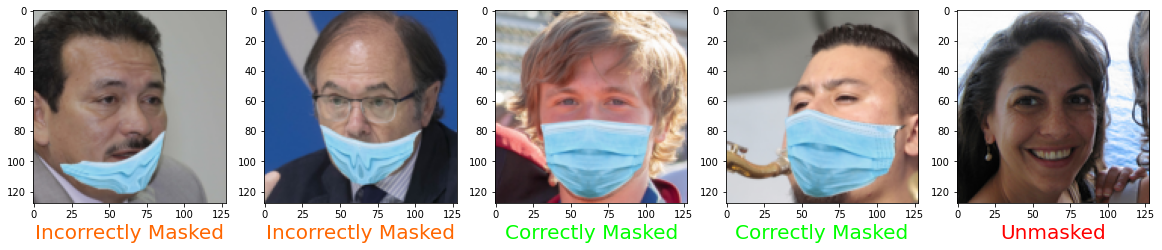

In [ ]:
label_text = { 0:"Correctly Masked",
              1:"Incorrectly Masked",
              2:"Unmasked"
              }
class_colors= {0: (0,1,0),    #Green
               1: (1,.4,0),  #Orange
               2: (1,0,0),    #Red
               }

plot_dataset = datasets.ImageFolder(PROJECT_PATH + '/Test/',
    transform= transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
]) )
plot_loader = DataLoader(
    plot_dataset,
    num_workers=1,
    batch_size=5,
    shuffle = True,
    # sampler=SubsetRandomSampler()
)
plt.figure(figsize=(20,5))
for images , label in plot_loader:
    pred = resnet(fixed_image_standardization(images).to(DEVICE)).cpu().detach()
    # print(pred)
    for i, img in enumerate(images):
        plt.subplot(1,5,i+1)
        plt.xlabel(label_text[np.argmax(pred[i]).item()], fontsize = 20, color =  class_colors[np.argmax(pred[i]).item()])
        plt.imshow(img.permute(1,2,0))
    break

# Image Implementation

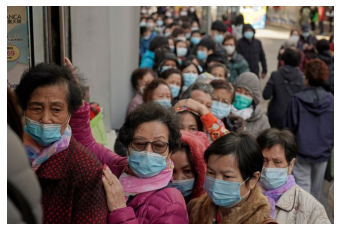

In [ ]:
image = cv2.imread(PROJECT_PATH + '/image.jpg')
# BGR => RGB
image = image[:,:,::-1]
plt.axis('off')
plt.imshow(image)

Number of detected faces: 15, Labels: [1, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0]


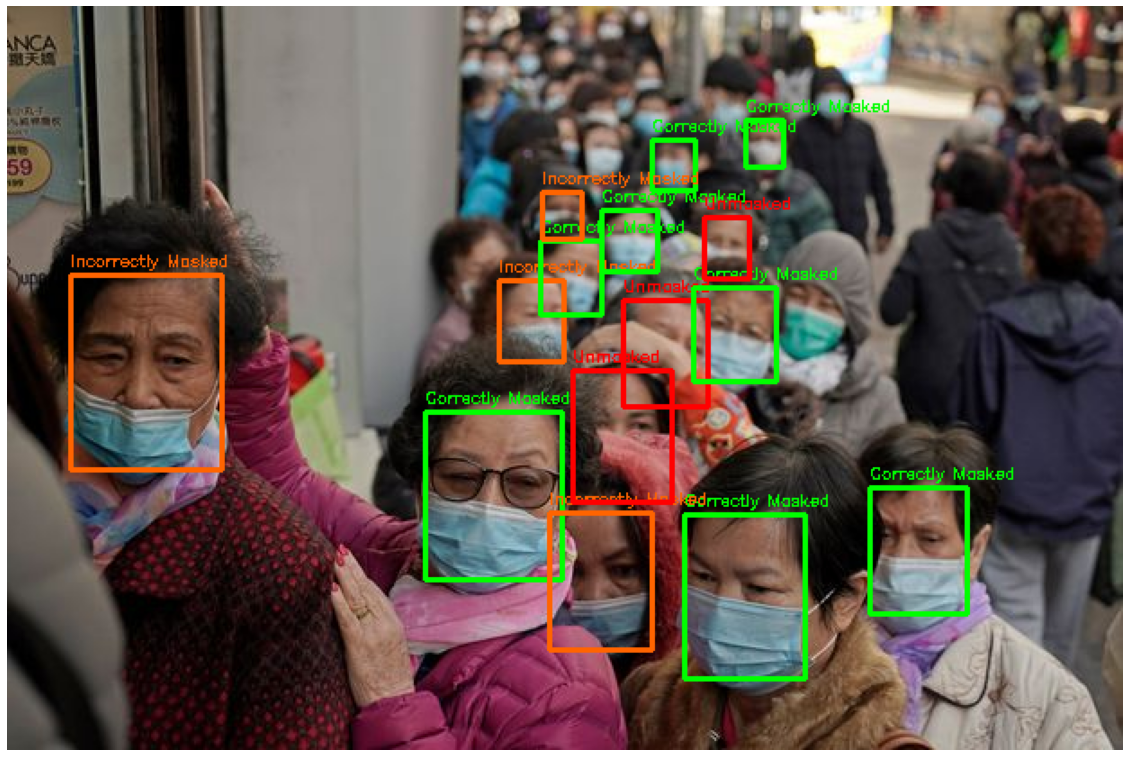

In [ ]:
image = cv2.imread(PROJECT_PATH + '/image.jpg')
# BGR => RGB
image = image[:,:,::-1]
detector =  MTCNN(image_size=128, keep_all= True, post_process = False, margin= 20)
detector_box =  MTCNN(image_size=128, device = DEVICE,)
# Detect Mask 
img_cropped = detector(image)
if type(img_cropped) != type(None):
    input_image = fixed_image_standardization(img_cropped/np.array([i.max() for i in img_cropped]).reshape(-1, 1, 1, 1))
    img_embedding = resnet(input_image.to(DEVICE))
    labels = torch.argmax(img_embedding, axis = -1)
    details = f"Number of detected faces: {len(img_cropped)}, Labels: {labels.cpu().tolist()}"
    # loop through detections and draw them on transparent overlay image
    faces = detector_box.detect(image)
    for face, label in zip(faces[0],labels):
        top, left, right, up = face
        label = label.item()
        image = cv2.rectangle(image, (top, left), (right, up), class_colors[label][::-1], 2)
        image = cv2.putText(image, label_text[label],
                            (int(top), int(left) - 5), cv2.FONT_HERSHEY_SIMPLEX, .3,
                            class_colors[label][::-1], 1)
else:
    details = f"No face found!"

print(details)
plt.figure(figsize= (20, 20))
plt.axis('off')
plt.imshow(image.get())

#Video Implementation

### Download video from Youtube

In [ ]:
youtube_video = YouTube('https://www.youtube.com/watch?v=ZeBU6rFcAzA')
print('Video: ', youtube_video.title)
saved_video = youtube_video.streams.get_by_resolution(resolution= '720p').download()

Video:  Why Do The Japanese Wear Masks In Public? | ASIAN BOSS


Or
### Upload Video

In [ ]:
saved_video = PROJECT_PATH + '/video1.mp4'

## Add mask detection to video

In [ ]:
cap = cv2.VideoCapture(saved_video)
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
out = cv2.VideoWriter('MaskDetection.mp4',fourcc, cap.get(5), (int(cap.get(3)),int(cap.get(4))))
 
detector =  MTCNN(image_size=128, keep_all= True, post_process = False, margin= 30 )
detector_box =  MTCNN(image_size=128, device = DEVICE)
#crop video
VideoFPS = cap.get(5)
start = 5 #s
end =  20 #s
#add detection to every frame and save frames to output file
for i in tqdm(range(int(end* VideoFPS))):
    if i < int(start* VideoFPS):
        continue
    _,frame = cap.read()  
    if type(frame) == type(None):
        continue
    # Detect faces
    boxes, _ = detector_box.detect(frame)
    if type(boxes) != type(None):
        #Change BGR to RGB for prediction
        RGBframe = frame[:,:,::-1]
        # Detect mask condition
        img_cropped = detector(RGBframe)
        img_embedding = resnet(fixed_image_standardization(img_cropped/img_cropped.max()).to(DEVICE))
        labels = torch.argmax(img_embedding, axis = -1)
        # Draw faces
        for box, label in zip(boxes, labels.tolist()):
            top, left, right, up = box
            cv2.rectangle(frame, (top, left), (right, up), class_colors[label], 2)
            cv2.putText(frame, label_text[label],
                                        (int(top), int(left) - 5),
                                         cv2.FONT_HERSHEY_SIMPLEX, .5,
                                        class_colors[label], 2)
    out.write(frame)
 
print('Done')
out.release()
d = input('Do you want to download the file? [y] / n : ')
if d != 'n':
    files.download('MaskDetection.mp4')


Done
Do you want to download the file? [y] / n : y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



































#Real-Time Webcam Implementation

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV RGB image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img[:,:,::-1]

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Details: </span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'Starting...';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);


      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "user"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
detector =  MTCNN(image_size=128, keep_all= True, post_process = False, margin= 0)
detector_box =  MTCNN(image_size=128, device = DEVICE)
# start streaming video from webcam
video_stream()
# label for video
details = 'Capturing...'
# initialze bounding box to empty
bbox = ''
while True:
    js_reply = video_frame(details, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    # Detect Mask 
    img_cropped = detector(frame)
    if type(img_cropped) != type(None):
        img_embedding = resnet(fixed_image_standardization(img_cropped/img_cropped.max()).to(DEVICE))
        labels = torch.argmax(img_embedding, axis = -1)
        details = f"Number of detected faces: {len(img_cropped)}, Labels: {labels.cpu().tolist()}"
        # create transparent overlay for bounding box
        bbox_array = np.zeros([480,640,4], dtype=np.uint8)
        # loop through detections and draw them on transparent overlay image
        faces = detector_box.detect(frame)
        for face, label in zip(faces[0],labels):
            top, left, right, up = face
            label = label.item()
            bbox_array = cv2.rectangle(bbox_array, (top, left), (right, up), class_colors[label][::-1], 2)
            bbox_array = cv2.putText(bbox_array, label_text[label],
                                (int(top), int(left) - 5), cv2.FONT_HERSHEY_SIMPLEX, .7,
                                class_colors[label][::-1], 2)
    else:
        details = f"No face found!"
        bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>